In [2]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [115]:
df_fraud = pd.read_parquet('C:/Users/Андрей/Downloads/transaction_fraud_data.parquet')

In [116]:
df_curr = pd.read_parquet('C:/Users/Андрей/Downloads/historical_currency_exchange.parquet')

# Придуманные гипотезы.

## Продуктовые:

1. Мошенники особенно активны с 1 по 4 час ночи.
2. Среди транзакций, проведенных вне страны клиента, гораздо больший процент мошеннических операций.
2. Среди сумм мошеннических транзакций больший процент аномалий.
3. Мошенники склонны проводить транзакцию в валюте той страны, в которой осуществляется транзакция. 

## Технические:

1. Создание флага часов активности мошенников (с 1 по 4 час).
2. Создание флага аномальных транзакций.
3. Создание флага проведения операции в иностранной валюте.
3. Данные для POS собраны неправильно, т.к. у этого канала все транзакции оказались мошенническими.
4. Идентификатор транзакции не является уникальным. Возможно, он собран некорректно.


In [42]:
df_fraud.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'last_hour_activity', 'is_fraud'],
      dtype='object')

Развернем словарь 'last_hour_activity' в колонки:

In [126]:
last_hour_df = pd.json_normalize(df_fraud['last_hour_activity'])

# Переименовываем колонки для ясности
last_hour_df.columns = [
    'last_hour_num_transactions',
    'last_hour_total_amount',
    'last_hour_unique_merchants',
    'last_hour_unique_countries',
    'last_hour_max_single_amount'
]

# Объединяем с основным DataFrame
df_fraud = pd.concat(
    [df_fraud.drop('last_hour_activity', axis=1), last_hour_df], 
    axis=1
)

In [44]:
df_fraud.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'is_fraud', 'last_hour_num_transactions', 'last_hour_total_amount',
       'last_hour_unique_merchants', 'last_hour_unique_countries',
       'last_hour_max_single_amount'],
      dtype='object')

transaction_id не является уникальным:

In [45]:
df_fraud['transaction_id'].duplicated().sum()

6460

Полных дублей нет:

In [46]:
df_fraud[df_fraud.duplicated(keep=False)] 

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,last_hour_num_transactions,last_hour_total_amount,last_hour_unique_merchants,last_hour_unique_countries,last_hour_max_single_amount


Процент мошеннических и обычных транзакций:

In [53]:
df_fraud['is_fraud'].value_counts(normalize=True)

is_fraud
False    0.800272
True     0.199728
Name: proportion, dtype: float64

Переводим amount в доллар США:

In [97]:
currs = list(df_curr.columns)
currs = [i for i in currs if i not in ['date', 'USD']]

In [98]:
currs

['AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'JPY', 'MXN', 'NGN', 'RUB', 'SGD']

In [100]:
df_merged = pd.merge(df_fraud, df_curr, left_on=df_fraud['timestamp'].dt.date, right_on='date')

for currency in df_fraud['currency'].unique():
    if currency == 'USD':
        df_fraud.loc[df_fraud['currency'] == currency, 'amount_usd'] = df_fraud['amount']
    elif currency in currs:
        rate_col = currency
        mask = df_fraud['currency'] == currency
        df_fraud.loc[mask, 'amount_usd'] = df_fraud['amount'] / df_merged[rate_col]

In [102]:
amount_inf = df_fraud.groupby('is_fraud')['amount_usd'].agg([
    'min', 
    lambda x: x.quantile(0.01), 
    'median', 
    'mean',
    lambda x: x.quantile(0.99),
    'max'
])

amount_inf = result.rename(columns={'<lambda_0>': '1% quantile',
                               '<lambda_1>': '99% quantile'})

Распределение сумм мошеннических и обычных транзакций отилчается. Среди мошеннических транзакций чаще встречаются аномально маленькие и большие транзакции.

In [103]:
amount_inf

,min,1%_quantile,mean,median,99%_quantile,max
is_fraud,,,,,,
False,6.232713,30.649905,459.782611,354.535911,2042.49255,3170.582484
True,0.002406,0.103626,874.606750,443.217866,7120.12732,15781.540993


Посчитаем процент выбросов (через 5 межквантильных размахов) в разрезе is_fraud

In [185]:
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR
    return (series < lower_bound) | (series > upper_bound)

# Добавим колонку с флагом аномалии
df_fraud['is_outlier'] = detect_outliers(df_fraud['amount'])

# Посчитаем процент аномалий в разрезе is_fraud
df_fraud.groupby('is_fraud')['is_outlier'].mean() * 100

is_fraud
False     2.618948
True     12.417250
Name: is_outlier, dtype: float64

C:\Program Files\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


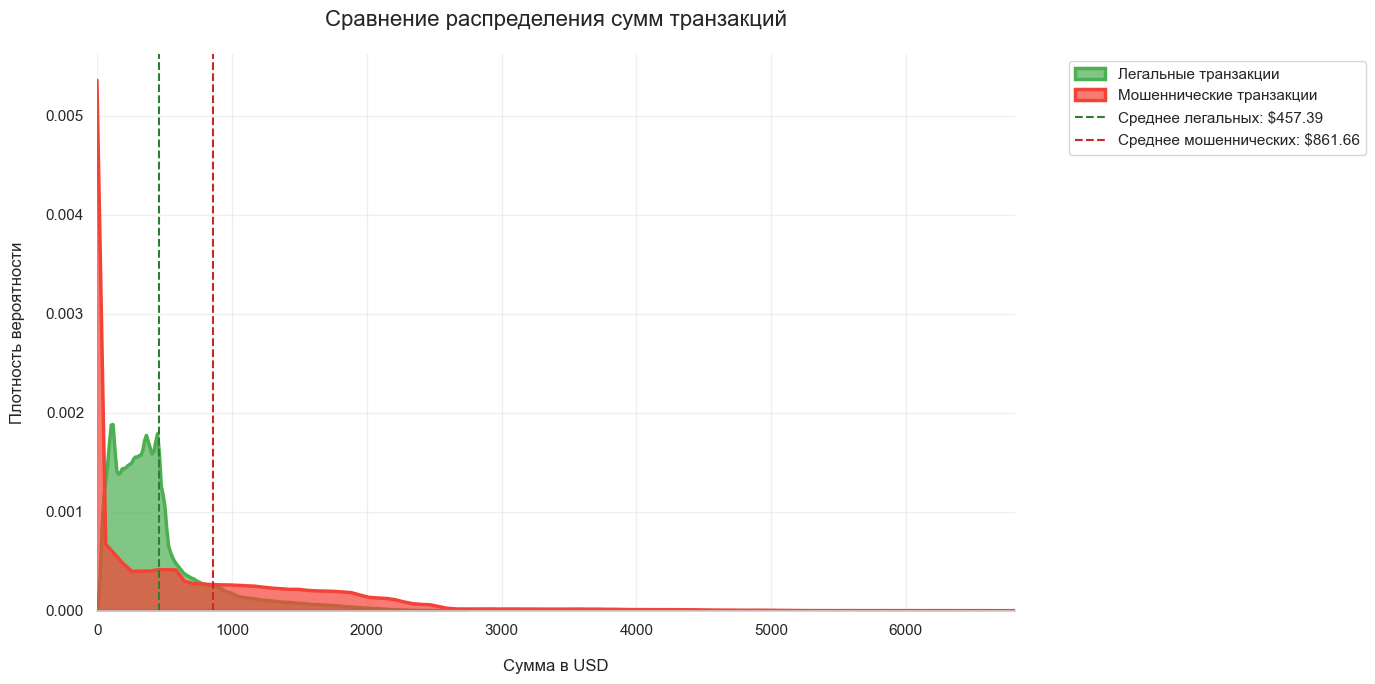

In [78]:
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(14, 7))

# Фильтрация данных
fraud = df_fraud[df_fraud['is_fraud'] == True]['amount_usd']
legit = df_fraud[df_fraud['is_fraud'] == False]['amount_usd']


fraud_clean = fraud[fraud <= fraud.quantile(0.999)]
legit_clean = legit[legit <= legit.quantile(0.999)]

sns.kdeplot(
    data=legit_clean,
    label='Легальные транзакции',
    color='#4CAF50',  # Зеленый
    linewidth=2.5,
    alpha=0.7,
    fill=True,
    bw_adjust=0.3  # Параметр сглаживания
)

sns.kdeplot(
    data=fraud_clean,
    label='Мошеннические транзакции',
    color='#F44336',  # Красный
    linewidth=2.5,
    alpha=0.7,
    fill=True,
    bw_adjust=0.3
)

plt.axvline(
    x=legit_clean.mean(),
    color='#2E7D32',
    linestyle='--',
    linewidth=1.5,
    label=f'Среднее легальных: ${legit_clean.mean():.2f}'
)

plt.axvline(
    x=fraud_clean.mean(),
    color='#C62828',
    linestyle='--',
    linewidth=1.5,
    label=f'Среднее мошеннических: ${fraud_clean.mean():.2f}'
)

# Настройка графика
plt.title('Сравнение распределения сумм транзакций', pad=20, fontsize=16)
plt.xlabel('Сумма в USD', labelpad=15)
plt.ylabel('Плотность вероятности', labelpad=15)
plt.xlim(0, max(legit_clean.quantile(0.99), fraud_clean.quantile(0.99)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

sns.despine(left=True)
plt.tight_layout()
plt.show()

Данные для POS-терминалов размечены неверно, т.к. все их транзакции - мошеннические

In [122]:
df_fraud.groupby(['channel'])['is_fraud'].mean()

channel
mobile    0.123878
pos       1.000000
web       0.123275
Name: is_fraud, dtype: float64

In [130]:
df_fraud.groupby('is_fraud')[['last_hour_num_transactions',
                              'last_hour_total_amount',
                              'last_hour_unique_merchants',
                              'last_hour_unique_countries',
                              'last_hour_max_single_amount']].agg(['mean', 'median'])

last_hour_num_transactions        last_hour_total_amount  \
                               mean median                   mean   
is_fraud                                                            
False                    408.262533  292.0           1.985784e+07   
True                     412.670479  296.0           2.015500e+07   

                       last_hour_unique_merchants         \
                median                       mean median   
is_fraud                                                   
False     1.012947e+07                  79.916723   95.0   
True      1.037572e+07                  80.445120   95.0   

         last_hour_unique_countries        last_hour_max_single_amount  \
                               mean median                        mean   
is_fraud                                                                 
False                     10.650769   12.0                1.719987e+06   
True                      10.710001   12.0                1.752255e+06   

                        
                median  
is_fraud                
False     1.229527e+06  
True      1.267038e+06

In [131]:
activity_features = ['last_hour_num_transactions',
                              'last_hour_total_amount',
                              'last_hour_unique_merchants',
                              'last_hour_unique_countries',
                              'last_hour_max_single_amount']

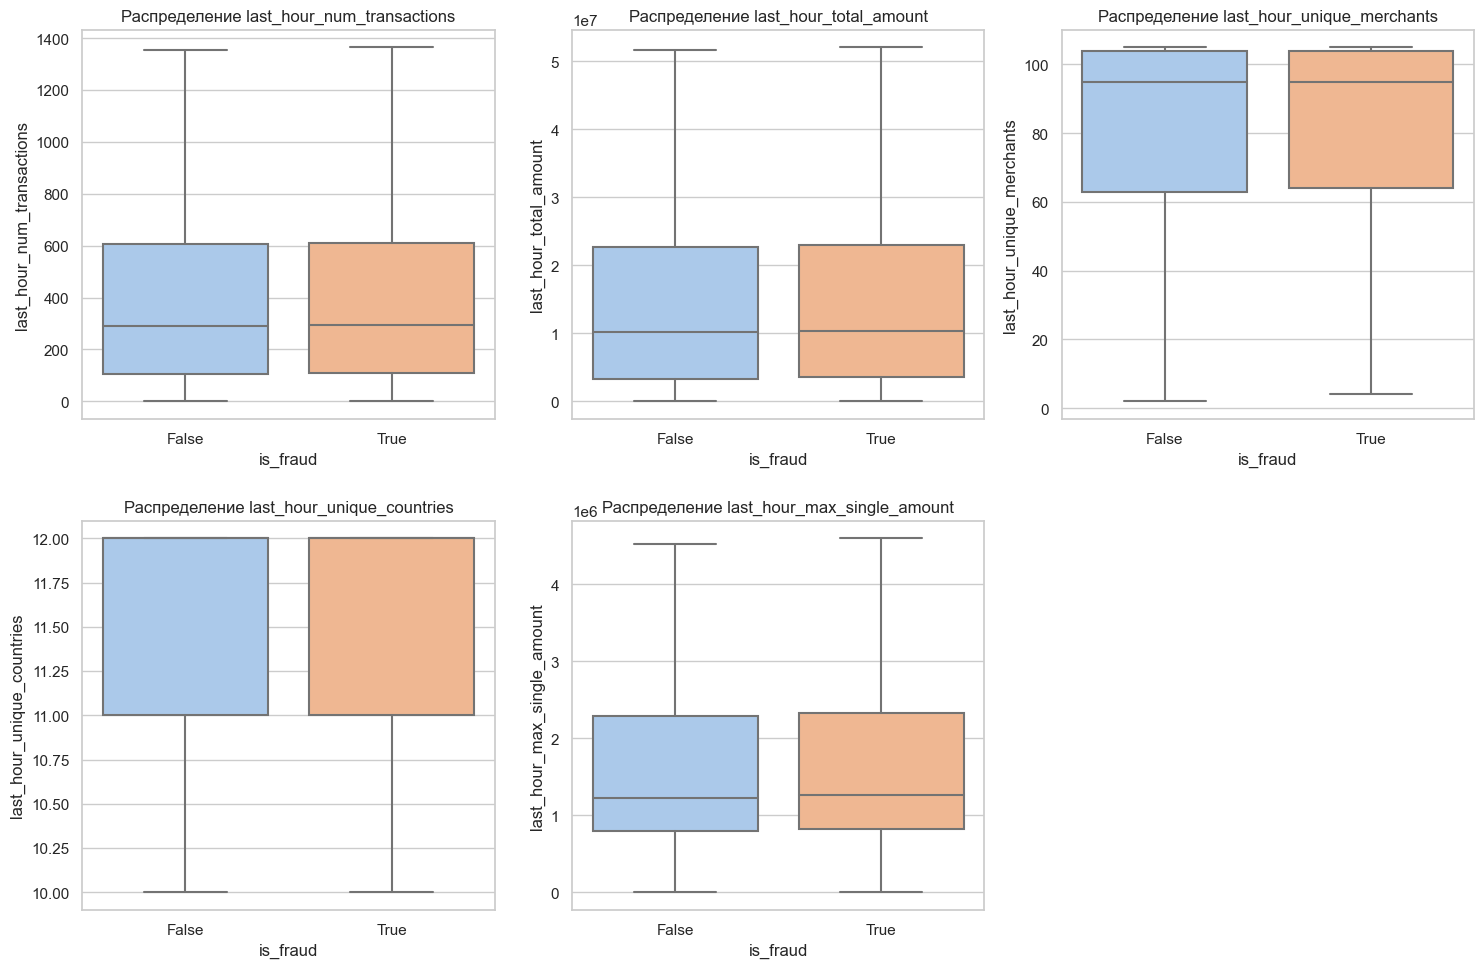

In [134]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(activity_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='is_fraud', y=feature, data=df_fraud, showfliers=False)
    plt.title(f'Распределение {feature}')
#     plt.yscale('log')  # Логарифмическая шкала для наглядности
plt.tight_layout()
plt.show()

In [140]:
card_risk = df_fraud.groupby('card_type')['is_fraud'].agg(['mean', 'count'])
card_risk = card_risk.sort_values('mean', ascending=False)
print("\nРиск мошенничества по типам карт:")
print(card_risk)


Риск мошенничества по типам карт:
                     mean    count
card_type                         
Basic Credit     0.199742  1415469
Platinum Credit  0.199731  1533013
Gold Credit      0.199729  1447260
Premium Debit    0.199721  1539661
Basic Debit      0.199720  1548363


Мошенники предпочитают дейстовать ночью:

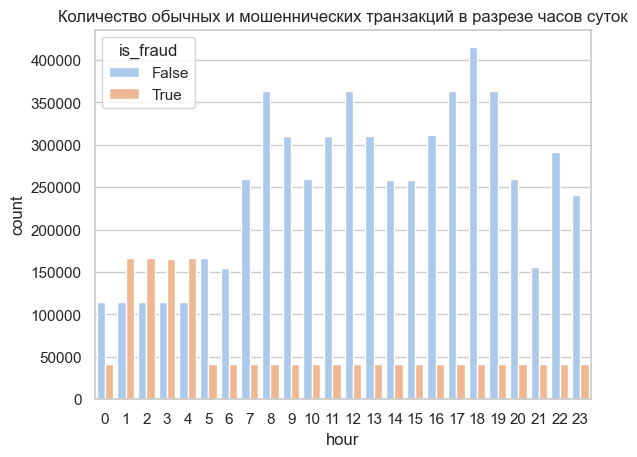

In [144]:
df_fraud['hour'] = df_fraud['timestamp'].dt.hour

sns.countplot(x='hour', hue='is_fraud', data=df_fraud)
plt.title('Количество обычных и мошеннических транзакций в разрезе часов суток')
plt.show()

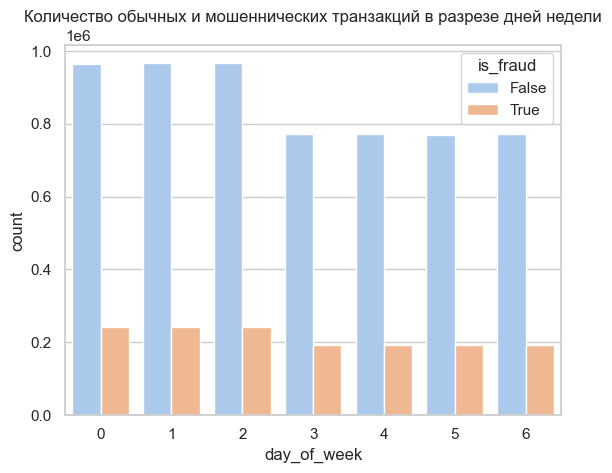

In [148]:
# 3. Анализ по дням недели
df_fraud['day_of_week'] = df_fraud['timestamp'].dt.dayofweek  # 0=Понедельник, 6=Воскресенье

sns.countplot(x='day_of_week', hue='is_fraud', data=df_fraud)
plt.title('Количество обычных и мошеннических транзакций в разрезе дней недели')
plt.show()

Мошеннические транзакции чаще проводятся за пределами страны клиента:

In [156]:
df_fraud.groupby('is_fraud')['is_outside_home_country'].mean()

is_fraud
False    0.173948
True     0.915474
Name: is_outside_home_country, dtype: float64

In [158]:
card_present_rates = df_fraud.groupby('is_card_present')['is_fraud'].mean()
print("Доля мошенничества при использовании карты (POS):")
print(card_present_rates)


Доля мошенничества при использовании карты (POS):
is_card_present
False    0.123475
True     1.000000
Name: is_fraud, dtype: float64


In [159]:
df_fraud.groupby('vendor_type')['is_fraud'].mean()

vendor_type
airlines     0.200535
booking      0.200174
casual       0.199186
events       0.200017
fast_food    0.200719
gaming       0.199558
hotels       0.199487
local        0.199642
major        0.199821
medical      0.198978
online       0.199310
pharmacy     0.199773
physical     0.200206
premium      0.199179
streaming    0.199320
supplies     0.199758
transport    0.201169
Name: is_fraud, dtype: float64

In [161]:
df_fraud.groupby('device')['is_fraud'].mean()

device
Android App        0.125070
Chip Reader        1.000000
Chrome             0.123710
Edge               0.116753
Firefox            0.126831
Magnetic Stripe    1.000000
NFC Payment        1.000000
Safari             0.126204
iOS App            0.122703
Name: is_fraud, dtype: float64

In [162]:
df_fraud.groupby('is_high_risk_vendor')['is_fraud'].mean()

is_high_risk_vendor
False    0.199642
True     0.199986
Name: is_fraud, dtype: float64

In [167]:
country_currency = {
    'USA': 'USD',
    'Germany': 'EUR',
    'UK': 'GBP',
    'Japan': 'JPY',
    'Canada': 'CAD',
    'Brazil': 'BRL',
    'Australia': 'AUD',
    'Mexico': 'MXN',
    'Nigeria': 'NGN',
    'Russia': 'RUB',
    'Singapore': 'SGD'
}

In [172]:
df_fraud['expected_currency'] = df_fraud['country'].map(country_currency)
df_fraud['currency_mismatch'] = df_fraud['currency'] != df_fraud['expected_currency']

Мошенники в среднем редко проводят транзакцию в иностранной валюте

In [175]:
df_fraud.groupby('currency_mismatch')['is_fraud'].mean()

currency_mismatch
False    0.209910
True     0.069143
Name: is_fraud, dtype: float64